In [1]:
from PIL import Image
import cv2 
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [2]:
import glob, os

laser_samples = []
os.chdir("../res/laser_samples/")
for file in glob.glob("*"):
    laser_samples.append(file)

In [3]:
def disp_file(path):
    # In OpenCV, images are in BGR
    # In Pillow, images are in RGB 
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    img = cv2.resize(img, (480, 360))
    display(Image.fromarray(img))

# Display cv2 image
def disp_img(cv_img):
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    cv_img = cv2.resize(cv_img, (480, 360))
    display(Image.fromarray(cv_img))


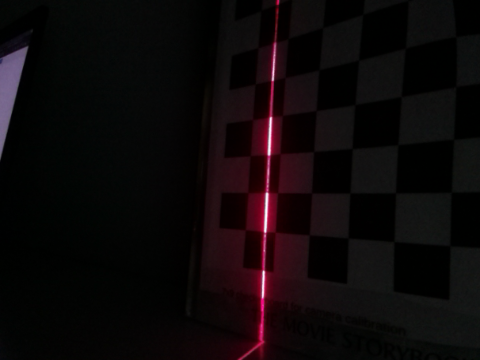

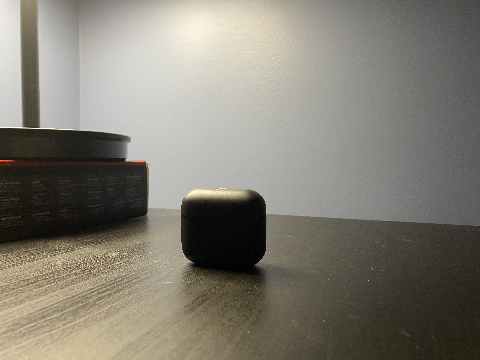

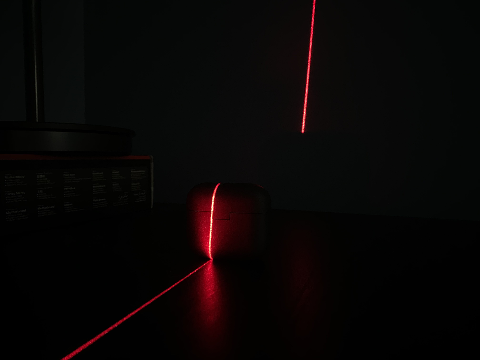

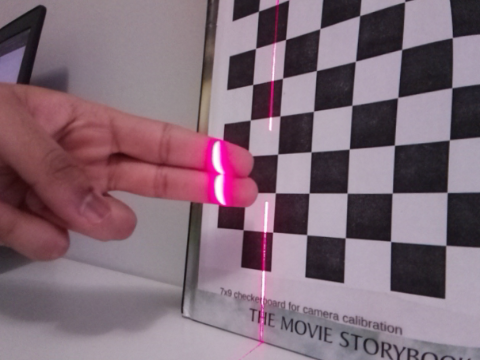

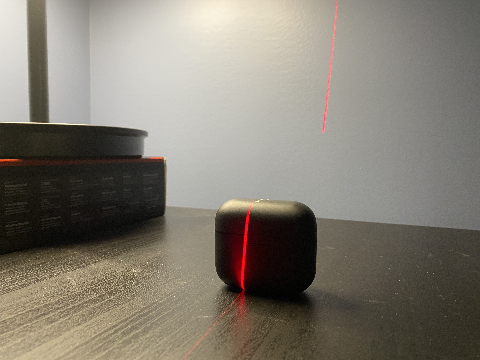

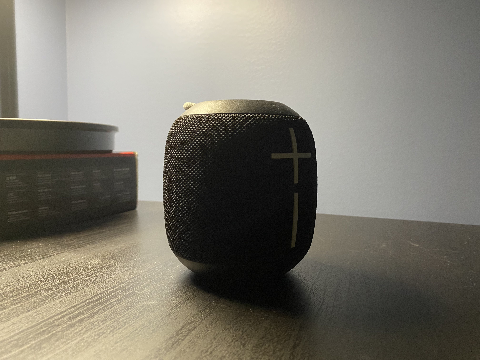

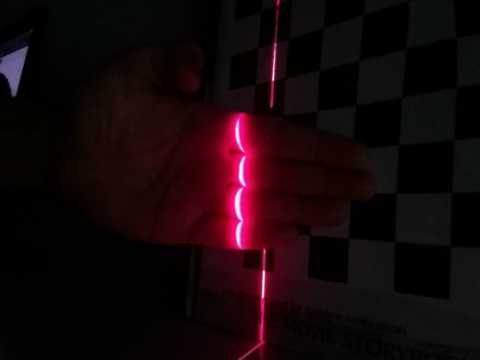

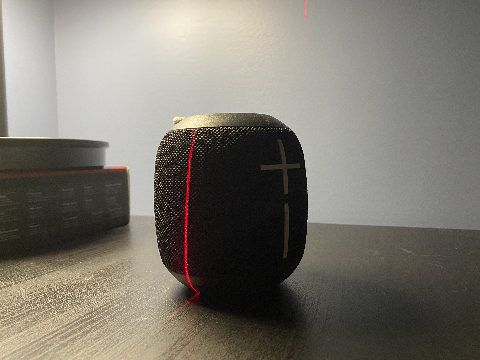

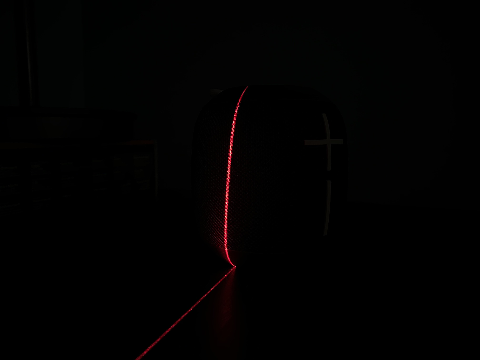

In [4]:
for file in laser_samples:
    disp_file(path=file)

## Idea 1. HSV Isolation
Manually tune the lower and upper bounds of HSV values to obtain laser line

In [5]:
import ipywidgets as widgets
from ipywidgets import interact, HBox

In [7]:
@interact
def hsv_isolation(lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255)):
    img = cv2.imread(laser_samples[6])

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    # inv = cv2.bitwise_not(mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)

    disp_img(res)

Widget Javascript not detected.  It may not be installed or enabled properly.


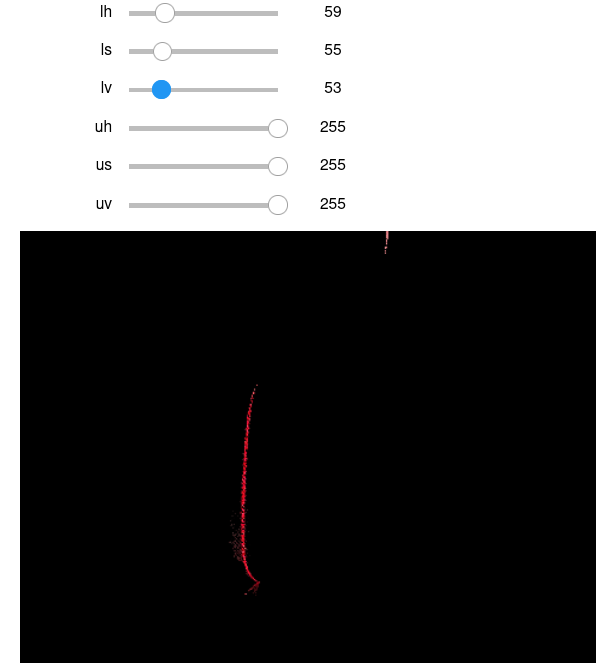

## Idea 2. Isolate Red Channel


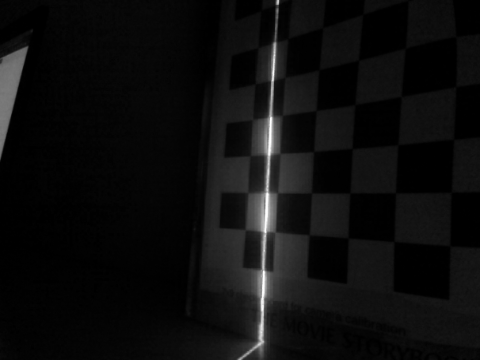

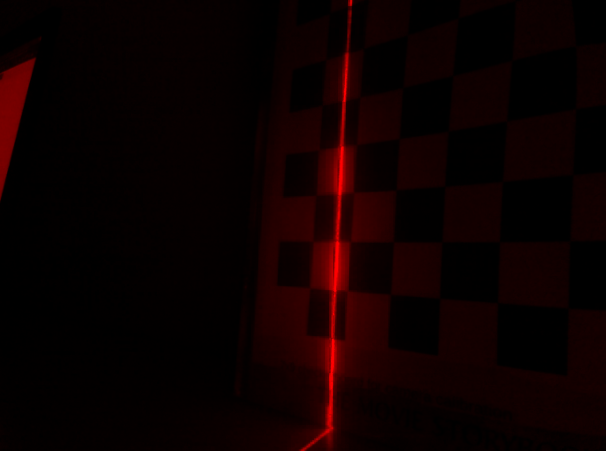

In [9]:
def show_red():
    img = cv2.imread(laser_samples[0])
    r = img[:, :, 2]  
    cv_img = cv2.resize(r, (480, 360))
    display(Image.fromarray(cv_img))

    # For displaying purposes, we turn off the blue and green channels, and then convert from BGR to RGB
    img[:,:,0] = 0
    img[:,:,1] = 0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img))
    
show_red()

## Idea 3. Edge Detection

This was not a good idea because it produced noise

In [ ]:
@interact
def edge_detect(minval=(0,255), maxval=(0,255)):

    # Load image
    img = cv2.imread(laser_samples[5])
    
    # Read only the red channel (remember BGR corresponds to B=0, G=1, R=2)
    r = img[...,2]
    print(r.shape)
    ret,r = cv2.threshold(img,250,255,0)
    
    r_blur = cv2.GaussianBlur(r,(5,5),cv2.BORDER_DEFAULT)
    edges = cv2.Canny(r_blur, minval,maxval)       
    
    img[:,:,0] = 0
    img[:,:,1] = 0
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(edges))  

    

In [ ]:
# Might be useful avenue to check out for optimizations

# # https://stackoverflow.com/questions/7722519/fast-rgb-thresholding-in-python-possibly-some-smart-opencv-code
# @interact
# def red_threshold(r1 = (0,255), r2 = (0,255), g1 = (0,255), g2 = (0,255), b1 = (0,255), b2 = (0,255)):
#     arr = cv2.imread(laser_samples[0])

# #     arr = np.array(np.asarray(img))

#     R = [(r1,r2),(g1,g2),(b1,b2)]
#     red_range = np.logical_and(R[0][0] < arr[:,:,0], arr[:,:,0] < R[0][1])
#     green_range = np.logical_and(R[1][0] < arr[:,:,0], arr[:,:,0] < R[1][1])
#     blue_range = np.logical_and(R[2][0] < arr[:,:,0], arr[:,:,0] < R[2][1])
#     valid_range = np.logical_and(red_range, green_range, blue_range)

#     arr[valid_range] = 200
#     arr[np.logical_not(valid_range)] = 0
#     display(Image.fromarray(arr)) 
# #     outim = Image.fromarray(arr)
    
    

## Idea 4. Skeletionization

This was also very noisy and was abandoned

In [ ]:
@interact
def skeletonize(thresh=(0,255)):
    # grab the grayscale image
    img = cv2.imread(laser_samples[5],0) 
    img = cv2.resize(img, (480, 360))
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)
    
    # Convert to binary image
    ret,img = cv2.threshold(img,thresh,255,0)
    # cross shaped kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while(not done):
        # Erosion: if any of the values in the kernel space have zero, the output pixel is 0
        #      Erosion removes tiny specks of noise and makes the area of interst thinner 
        # Dilation: if any of the values in the kernel space have one, then the output pixel is 1
        #      Dilation fills in holes 
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
            
    display(Image.fromarray(skel))


## Pipeline 1. GaussianBlur --> HSV Thresholding --> skeletonization
Note: Abandoned Method

In [ ]:
@interact
def pipeline1(lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255), thresh=(0,255)):
    img = cv2.imread(laser_samples[5])
    img = cv2.resize(img, (480, 360))
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = cv2.GaussianBlur(hsv,(5,5),cv2.BORDER_DEFAULT)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only blue colors
    mask = cv2.inRange(hsv, lower_colour, upper_colour)
    # inv = cv2.bitwise_not(mask)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)

    img = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    # grab the grayscale image
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    # Convert to binary image
    ret,img = cv2.threshold(img,172,255,0)
    # cross shaped kernel
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while(not done):
        # Erosion: if any of the values in the kernel space have zero, the output pixel is 0
        #      Erosion removes tiny specks of noise and makes the area of interst thinner 
        # Dilation: if any of the values in the kernel space have one, then the output pixel is 1
        #      Dilation fills in holes 
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
    

    display(Image.fromarray(skel))

## Idea 5. Brightest Pixel Per Row

In [ ]:
x = np.array([[3, 5, 1], [4, 1, 8], [9, 2, 1]], np.int32)

print(x)

max_loc = np.argmax(x, axis=1)
print(max_loc)

out = np.zeros((3,3))
print(out)

out[np.arange(len(max_loc)), max_loc] = 255

print(out)

In [ ]:
@interact
def bppr(thresh=(0,255), lh=(0,255), ls=(0,255), lv=(0,255), uh=(0,255), us=(0,255), uv=(0,255)):
    img = cv2.imread(laser_samples[0])
    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([lh, ls, lv])
    upper_colour = np.array([uh, us, uv])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,thresh,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)
    
    
    display(Image.fromarray(res)) 


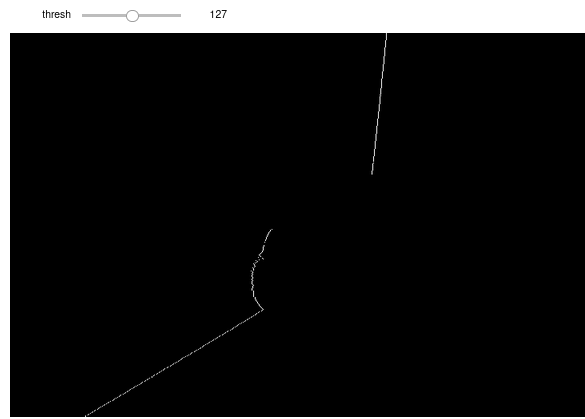

In [10]:
# WORKING WITH PRE-SET HSV THRESHOLDS
@interact
def bppr(thresh=(0,255)):
    img = cv2.imread(laser_samples[0])
    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,thresh,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)
    
    
    display(Image.fromarray(res)) 

Widget Javascript not detected.  It may not be installed or enabled properly.


## Pipeline 2. (Red Channel --> Thresholding --> BPPR) BITWISE_AND HSV Isolation

Best solution thus far

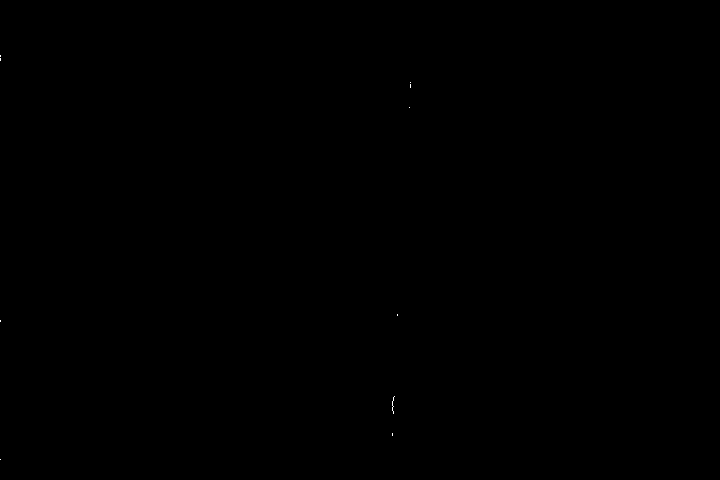

In [11]:
def pipeline3():
    img = cv2.imread(laser_samples[0])

    # Resize for illustration purposes
    img = cv2.resize(img, (720, 480))
    
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_colour = np.array([146, 62, 0])
    upper_colour = np.array([255, 255, 255])

    # Threshold the HSV image to get only get red colour
    mask = cv2.inRange(hsv, lower_colour, upper_colour)

    
    # Isolate the red channel
    img = img[...,2]
    
    ret,img = cv2.threshold(img,144,255,0)
    
    # For each row, get the position of the highest intensity
    bppr = np.argmax(img, axis=1)
    # Create emptry array of zeros of same size as img
    out = np.full_like(img, 0)
    # Set the highest intensity pixel locations to 255
    out[np.arange(len(bppr)), bppr] = 255
    
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(out,out, mask= mask)

    display(Image.fromarray(res)) 
    
pipeline3()


